# <b><div style='padding:15px;background-color:blue;color:white;border-radius:2px;font-size:110%;text-align: center'>Text Classifier App with Hugging Face, BERT, and Comet</div></b>

# 1. Install Required Libraries

In [2]:
!pip install -q comet_ml gradio


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# 2. Initialize Comet and HuggingFace

In [3]:
import comet_ml

comet_ml.init(project_name="text-classification-with-transfomers")

In [4]:
from huggingface_hub import notebook_login

notebook_login()

# 3. Load Data

In [5]:
from datasets import load_dataset

raw_datasets = load_dataset("rotten_tomatoes")

In [6]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [7]:
raw_datasets["train"][0]

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
 'label': 1}

# 4. Understand Data

In [8]:
# From Datasets to Pandas DataFrames
import pandas as pd

raw_datasets.set_format(type="pandas")
df = raw_datasets["train"][:]
df.head()

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


In [9]:
def label_int2str(row):
    return raw_datasets["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,the rock is destined to be the 21st century's ...,1,pos
1,"the gorgeously elaborate continuation of "" the...",1,pos
2,effective but too-tepid biopic,1,pos
3,if you sometimes like to go to the movies to h...,1,pos
4,"emerges as something rare , an issue movie tha...",1,pos


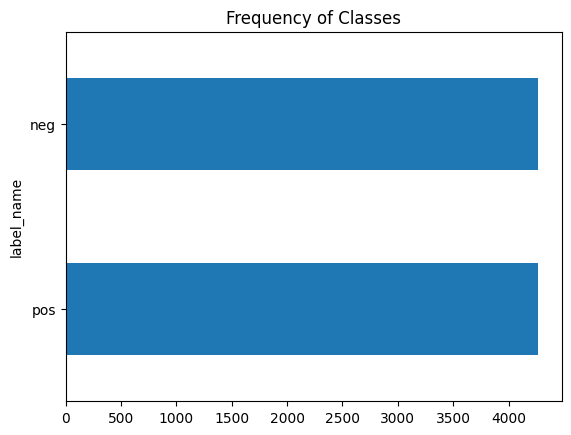

In [10]:
# Label Distribution
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

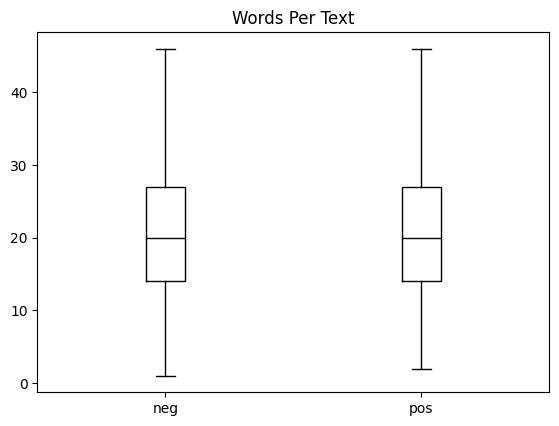

In [11]:
# Text long
df["Words Per Text"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Text", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [12]:
raw_datasets.reset_format()

# 5. Preprocess Data

In [13]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [14]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [15]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1066
    })
})

In [16]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 6. Setup Evaluation Function

In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def get_example(index):
    return tokenized_datasets["test"][index]["text"]


def compute_metrics(pred):
    experiment = comet_ml.get_global_experiment()

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro"
    )
    acc = accuracy_score(labels, preds)

    if experiment:
        epoch = int(experiment.curr_epoch) if experiment.curr_epoch is not None else 0
        experiment.set_epoch(epoch)
        experiment.log_confusion_matrix(
            y_true=labels,
            y_predicted=preds,
            file_name=f"confusion-matrix-epoch-{epoch}.json",
            labels=["negative", "postive"],
            index_to_example_function=get_example,
        )

    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# 7. Setup Transformer Model

In [18]:
from transformers import AutoModelForSequenceClassification

id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 8. Run Training

In [20]:
from transformers import TrainingArguments, Trainer

%env COMET_MODE=ONLINE
%env COMET_LOG_ASSETS=TRUE

training_args = TrainingArguments(
    output_dir="my_distilbert_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
    report_to=["comet_ml"],
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

trainer.train()

env: COMET_MODE=ONLINE
env: COMET_LOG_ASSETS=TRUE


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/franhinomut/text-classification-with-transfomers/1d1c5d48f9104f3289d7b63f171a5457



  0%|          | 0/1602 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
COMET INFO: Couldn't find a Git repository in 'c:\\Users\\Usuario\\OneDrive\\Workplace\\Projects_2311\\Text_Classifier_App' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


{'loss': 0.4172, 'learning_rate': 1.3757802746566792e-05, 'epoch': 0.94}


  0%|          | 0/67 [00:00<?, ?it/s]

{'eval_loss': 0.3729272186756134, 'eval_accuracy': 0.8386491557223265, 'eval_f1': 0.838580403425738, 'eval_precision': 0.8392270940216146, 'eval_recall': 0.8386491557223265, 'eval_runtime': 38.336, 'eval_samples_per_second': 27.807, 'eval_steps_per_second': 1.748, 'epoch': 1.0}
{'loss': 0.2351, 'learning_rate': 7.515605493133583e-06, 'epoch': 1.87}


  0%|          | 0/67 [00:00<?, ?it/s]

{'eval_loss': 0.43759217858314514, 'eval_accuracy': 0.8442776735459663, 'eval_f1': 0.8442689027116269, 'eval_precision': 0.844355250418097, 'eval_recall': 0.8442776735459663, 'eval_runtime': 93.9333, 'eval_samples_per_second': 11.348, 'eval_steps_per_second': 0.713, 'epoch': 2.0}
{'loss': 0.1635, 'learning_rate': 1.2734082397003748e-06, 'epoch': 2.81}


  0%|          | 0/67 [00:00<?, ?it/s]

{'eval_loss': 0.5331581234931946, 'eval_accuracy': 0.850844277673546, 'eval_f1': 0.8508430963429304, 'eval_precision': 0.8508553928470853, 'eval_recall': 0.850844277673546, 'eval_runtime': 57.7099, 'eval_samples_per_second': 18.472, 'eval_steps_per_second': 1.161, 'epoch': 3.0}
{'train_runtime': 4808.8344, 'train_samples_per_second': 5.321, 'train_steps_per_second': 0.333, 'train_loss': 0.2629753385441431, 'epoch': 3.0}


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/franhinomut/text-classification-with-transfomers/1d1c5d48f9104f3289d7b63f171a5457
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch [7]                   : (0.94, 3.0)
COMET INFO:     eval_accuracy [3]           : (0.8386491557223265, 0.850844277673546)
COMET INFO:     eval_f1 [3]                 : (0.838580403425738, 0.8508430963429304)
COMET INFO:     eval_loss [3]               : (0.3729272186756134, 0.5331581234931946)
COMET INFO:     eval_precision [3]          : (0.8392270940216146, 0.8508553928470853)
COMET INFO:     eval_recall [3]             : (0.8386491557223265, 0.850844277673546)
COMET INFO:     eval_r

TrainOutput(global_step=1602, training_loss=0.2629753385441431, metrics={'train_runtime': 4808.8344, 'train_samples_per_second': 5.321, 'train_steps_per_second': 0.333, 'train_loss': 0.2629753385441431, 'epoch': 3.0})

In [21]:
trainer.push_to_hub()

'https://huggingface.co/franhinomut/my_distilbert_model/tree/main/'

# 9. Inference

In [22]:
text = "This is a great movie. It may be my favourite."

In [23]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="Tirendaz/my_distilbert_model")
classifier(text)

c:\Users\Usuario\OneDrive\Workplace\Projects_2311\Text_Classifier_App\venv_name\Lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Usuario\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


[{'label': 'POSITIVE', 'score': 0.9761661887168884}]

# 10. Deploy

In [24]:
import gradio as gr
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="Tirendaz/my_distilbert_model")

def text_classification(text):
    result= classifier(text)
    sentiment_label = result[0]['label']
    sentiment_score = result[0]['score']
    formatted_output = f"This sentiment is {sentiment_label} with the probability {sentiment_score*100:.2f}%"
    return formatted_output

examples=["This is wonderful movie!", "The movie was really bad; I didn't like it."]

io = gr.Interface(fn=text_classification, 
                         inputs= gr.Textbox(lines=2, label="Text", placeholder="Enter title here..."), 
                         outputs=gr.Textbox(lines=2, label="Text Classification Result"),
                         title="Text Classification",
                         description="Enter a text and see the text classification result!",
                         examples=examples)

io.launch(inline=False, share=True)


experiment = comet_ml.Experiment()
experiment.add_tag("text-classifier")

io.integrate(comet_ml=experiment)

Running on local URL:  http://127.0.0.1:7860


OSError: [WinError 225] No se pudo completar la operación porque el archivo contiene un virus o software potencialmente no deseado: 'c:\\Users\\Usuario\\OneDrive\\Workplace\\Projects_2311\\Text_Classifier_App\\venv_name\\Lib\\site-packages\\gradio\\frpc_windows_amd64_v0.2'